In [ ]:

def reduce_variance(df, feature_cols, shrink_factor=0.5, noise_std=0.02):

    df_modified = df.copy()

    for col in feature_cols:
        df_modified[col] = pd.to_numeric(df_modified[col], errors='coerce')
        df_modified[col].fillna(df_modified[col].mean(), inplace=True)  # Fill missing values with mean

        mean_val = df_modified[col].mean()

        # Reduce variance by shifting values closer to the mean
        df_modified[col] = mean_val + shrink_factor * (df_modified[col] - mean_val)

    # Step 2: Add small Gaussian noise for smoothness
    noise = np.random.normal(loc=0, scale=noise_std, size=df_modified[feature_cols].shape)
    df_modified[feature_cols] += noise

    return df_modified

In [ ]:

def create_subseq(data):
  subarray_shape=(5,5)
  subarrays=[]
  num_subarrays=data.shape[0]//subarray_shape[1]

  for i in range(num_subarrays):
          start_index = i * subarray_shape[1]
          end_index = start_index + subarray_shape[1]
          subarray = data[start_index:end_index, :]
          subarrays.append(subarray)

  subarrays = np.array(subarrays)
  subarrays = np.expand_dims(subarrays, axis=-1)
  return subarrays

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

df_normal=pd.read_csv('df_500_patients.csv')
df_normal.drop(columns=['ABPs','ABPd'],inplace=True)
cols=[ 'ABPm', 'HR', 'RR', 'SpO2', 'Temperature C']
df_normal= reduce_variance(df_normal,cols)
X_normal=df_normal[cols]
scaler_2=MinMaxScaler()
X_normal=scaler_2.fit_transform(X_normal)
X_normal_subseq=create_subseq(X_normal)

df=pd.read_csv('final_data2.csv')
cols=[ 'ABPm' , 'HR', 'RR', 'SpO2', 'Temperature C']
labels=['label','label2','final_label','final_label2']
X=df[cols]
Y=df[labels]
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=42)
X_train=scaler_2.fit_transform(X_train)
X_test=scaler_2.transform(X_test)


X_train_sub=create_subseq(X_train)
X_test_sub=create_subseq(X_test)
X_sub=create_subseq(X.to_numpy())


<ipython-input-1-540ca72e8bf5>:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_modified[col].fillna(df_modified[col].mean(), inplace=True)  # Fill missing values with mean


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Define the Vanilla Autoencoder
def build_vanilla_autoencoder(input_dim, encoding_dim=32):
    """
    Build a basic autoencoder with dense layers

    Args:
        input_dim: dimension of input data (sequence_length * features)
        encoding_dim: dimension of the encoded representation

    Returns:
        autoencoder: complete autoencoder model
    """
    # Input layer
    input_layer = Input(shape=(input_dim,))

    # Encoder layers
    encoded = Dense(128, activation='relu')(input_layer)
    encoded = Dropout(0.2)(encoded)
    encoded = Dense(64, activation='relu')(encoded)
    encoded = Dense(encoding_dim, activation='relu')(encoded)

    # Decoder layers
    decoded = Dense(64, activation='relu')(encoded)
    decoded = Dropout(0.2)(decoded)
    decoded = Dense(128, activation='relu')(decoded)
    decoded = Dense(input_dim, activation='sigmoid')(decoded)

    # Create model
    autoencoder = Model(input_layer, decoded)

    # Compile autoencoder
    autoencoder.compile(optimizer='adam', loss='mse')

    return autoencoder

# Prepare sequence data from flattened format
def reshape_sequences_for_autoencoder(X_sub, seq_len, features):
    """
    Reshape 3D sequence data to 2D for vanilla autoencoder
    """
    # Flatten each sequence to a single vector
    return X_sub.reshape(X_sub.shape[0], seq_len * features)

# Function to train the model and detect anomalies
def train_and_detect_anomalies(X_normal_subseq, X_sub, Y, cols, threshold=1.5):
    """
    Train the autoencoder on normal data and detect anomalies

    Args:
        X_normal_subseq: normal data sequences
        X_sub: test data sequences
        Y: labels for evaluation
        cols: column names
        threshold: z-score threshold for anomaly detection
    """
    # Get dimensions
    seq_len = X_normal_subseq.shape[1]
    features = X_normal_subseq.shape[2]

    # Reshape for vanilla autoencoder
    X_normal_flat = reshape_sequences_for_autoencoder(X_normal_subseq, seq_len, features)
    X_test_flat = reshape_sequences_for_autoencoder(X_sub, seq_len, features)

    # Build and train the model
    autoencoder = build_vanilla_autoencoder(X_normal_flat.shape[1])

    # Define early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    )

    # Train the model
    history = autoencoder.fit(
        X_normal_flat, X_normal_flat,
        epochs=20,
        batch_size=32,
        validation_split=0.2,
        callbacks=[early_stopping],
        verbose=1
    )

    # Get predictions
    X_pred_flat = autoencoder.predict(X_test_flat)

    # Calculate reconstruction error for each sample
    reconstruction_errors = np.mean(np.square(X_test_flat - X_pred_flat), axis=1)

    # Find anomalies based on reconstruction error
    error_mean = np.mean(reconstruction_errors)
    error_std = np.std(reconstruction_errors)
    z_scores = (reconstruction_errors - error_mean) / error_std
    anomaly_indices = np.where(z_scores > threshold)[0]

    # Feature-specific anomalies
    anomalies_dict = {}
    POINT_ANOMALIES = set()

    # Reshape predictions and original data back to original format
    X_test_reshaped = X_test_flat.reshape(-1, features)
    X_pred_reshaped = X_pred_flat.reshape(-1, features)

    for idx, col in enumerate(cols):
        # Calculate errors for this feature
        feature_errors = np.abs(X_test_reshaped[:, idx] - X_pred_reshaped[:, idx])
        mae_std = np.std(feature_errors)
        mean_diff = np.mean(feature_errors)

        # Z-score based detection
        z_scores = (feature_errors - mean_diff) / mae_std
        feature_anomalies = np.where(np.abs(z_scores) > threshold)[0]

        anomalies_dict[col] = feature_anomalies
        POINT_ANOMALIES = POINT_ANOMALIES.union(set(feature_anomalies))

    # Create binary labels for predicted anomalies
    anomalies_label = np.zeros(len(Y))
    anomalies_label[list(POINT_ANOMALIES)] = 1

    # Calculate metrics
    print("## Metrics for Vanilla Autoencoder")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], anomalies_label)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], anomalies_label)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], anomalies_label)}")



    return anomalies_label, reconstruction_errors, anomalies_dict , POINT_ANOMALIES

# Example usage
if __name__ == "__main__":
    # Assuming X_normal_subseq, X_sub, and Y are already prepared
    # cols = ['ABPm', 'HR', 'RR', 'SpO2', 'Temperature C']

    # Train model and detect anomalies
    anomalies_label, reconstruction_errors, anomalies_dict , POINT_ANOMALIES = train_and_detect_anomalies(
        X_normal_subseq, X_sub, Y, cols)

Epoch 1/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 0.0161 - val_loss: 0.0046
Epoch 2/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0053 - val_loss: 0.0037
Epoch 3/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0045 - val_loss: 0.0031
Epoch 4/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0041 - val_loss: 0.0028
Epoch 5/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 6/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0036 - val_loss: 0.0023
Epoch 7/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0033 - val_loss: 0.0023
Epoch 8/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0032 - val_loss: 0.0022
Epoch 9/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0031 - val_loss: 0.0023
Epoch 10/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 0.0030 - val_loss: 0.0021
Epoch 11/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 0.0029 - val_loss: 0.0022
Epoch 12/20
719/719 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step

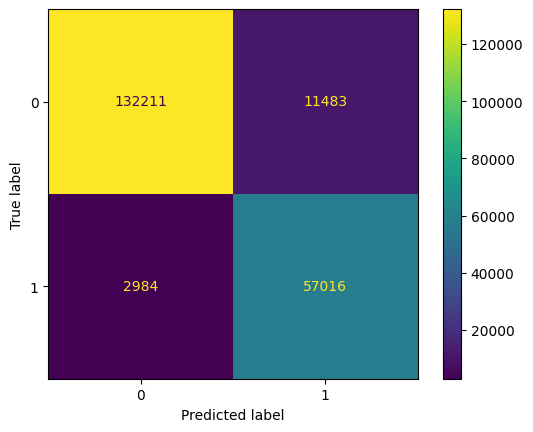

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
anomalies_label=np.zeros(Y.shape[0])
anomalies_label[list(POINT_ANOMALIES)]=1
conf_matrix=confusion_matrix(Y['final_label'],anomalies_label)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

ISOLATION FOREST

Training Isolation Forest model...
Detecting anomalies...

## Metrics for Isolation Forest (Overall)
Accuracy for point anomaly detection: 0.8681699019116911
Precision for point anomaly detection: 0.848790959025191
Recall for point anomaly detection: 0.6722

## Metrics for Isolation Forest (Feature-based)
Accuracy for point anomaly detection: 0.8263375455339873
Precision for point anomaly detection: 0.6486718184013524
Recall for point anomaly detection: 0.8953833333333333


<Figure size 800x600 with 0 Axes>

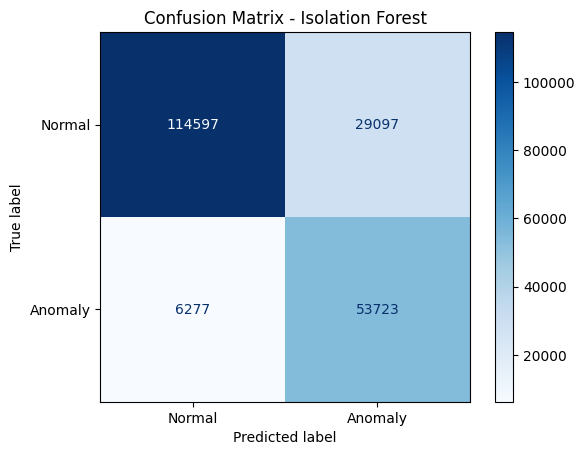

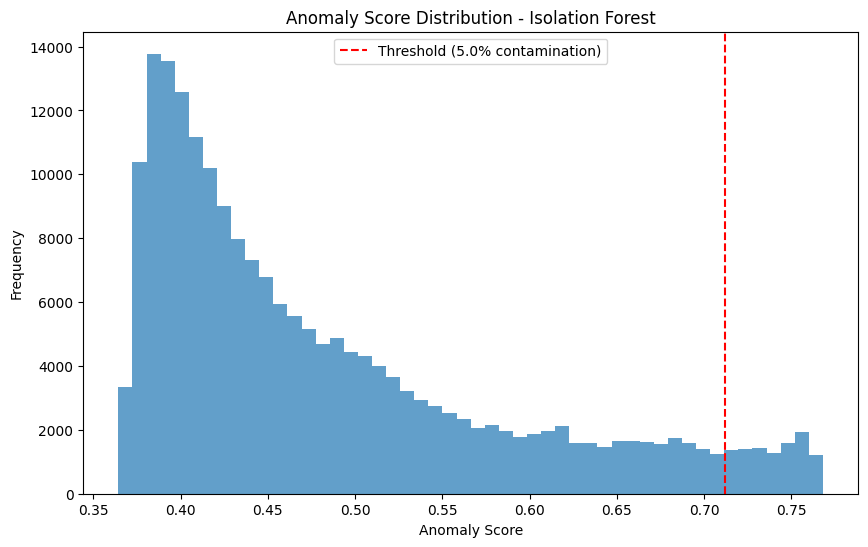

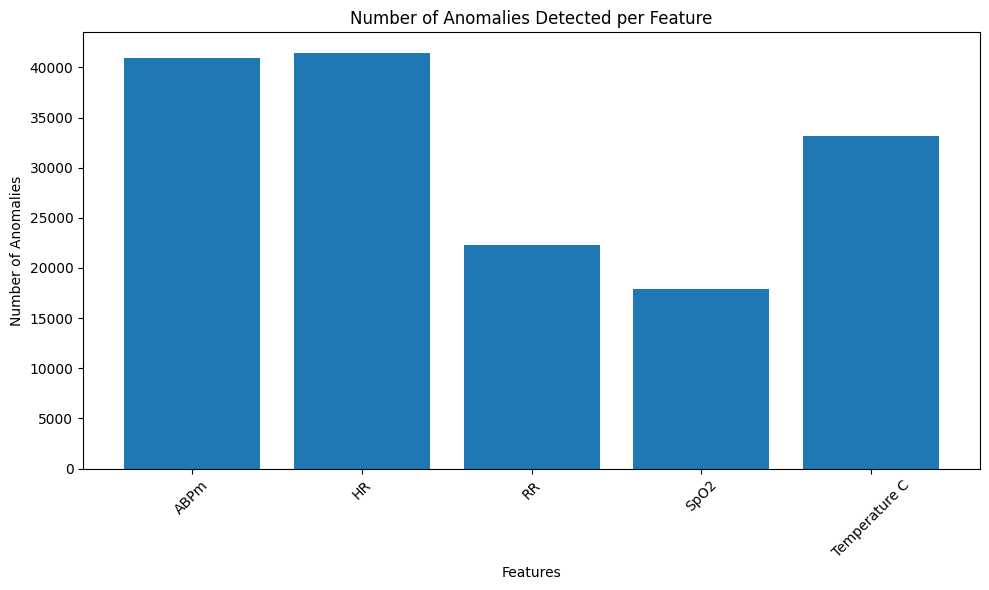

In [ ]:
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_and_detect_anomalies_isolation_forest(X_normal, X_test, Y, cols,
                                                contamination=0.05, n_estimators=100,
                                                max_samples='auto', random_state=42):
    """
    Train Isolation Forest on normal data and detect anomalies in test data

    Args:
        X_normal: normal data (without anomalies)
        X_test: test data (potentially with anomalies)
        Y: labels for evaluation
        cols: column names
        contamination: expected proportion of anomalies
        n_estimators: number of trees in the forest
        max_samples: number of samples to draw for each tree
        random_state: for reproducibility
    """
    # Initialize the model
    model = IsolationForest(
        n_estimators=n_estimators,
        max_samples=max_samples,
        contamination=contamination,
        random_state=random_state,
        n_jobs=-1  # Use all available cores
    )

    # Fit the model on normal data
    print("Training Isolation Forest model...")
    model.fit(X_normal)

    # Predict anomalies (1 for normal, -1 for anomalies)
    print("Detecting anomalies...")
    predictions_raw = model.predict(X_test)

    # Convert to binary labels (0 for normal, 1 for anomalies)
    anomalies_label = np.zeros(len(predictions_raw))
    anomalies_label[predictions_raw == -1] = 1

    # Get anomaly scores (-ve means more anomalous)
    anomaly_scores = -model.score_samples(X_test)

    # Feature-specific anomalies using individual Isolation Forests
    anomalies_dict = {}
    POINT_ANOMALIES = set()
    feature_models = {}

    for idx, col in enumerate(cols):
        # Train a separate model for each feature
        feature_model = IsolationForest(
            n_estimators=n_estimators,
            max_samples=max_samples,
            contamination=contamination,
            random_state=random_state
        )

        # Reshape to 2D array with single feature
        X_normal_feature = X_normal[:, idx].reshape(-1, 1)
        X_test_feature = X_test[:, idx].reshape(-1, 1)

        # Fit and predict
        feature_model.fit(X_normal_feature)
        feature_predictions = feature_model.predict(X_test_feature)

        # Get indices of anomalies for this feature
        feature_anomalies = np.where(feature_predictions == -1)[0]

        # Store results
        anomalies_dict[col] = feature_anomalies
        POINT_ANOMALIES = POINT_ANOMALIES.union(set(feature_anomalies))
        feature_models[col] = feature_model

    # Convert to list for indexing
    POINT_ANOMALIES_list = list(POINT_ANOMALIES)

    # Create new binary labels based on feature-specific anomalies
    feature_based_labels = np.zeros(len(Y))
    feature_based_labels[POINT_ANOMALIES_list] = 1

    # Calculate metrics for overall model
    print("\n## Metrics for Isolation Forest (Overall)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], anomalies_label)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], anomalies_label)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], anomalies_label)}")

    # Calculate metrics for feature-based detection
    print("\n## Metrics for Isolation Forest (Feature-based)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], feature_based_labels)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], feature_based_labels)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], feature_based_labels)}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(Y['final_label'], feature_based_labels)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Isolation Forest')
    plt.show()

    # Plot anomaly score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(anomaly_scores, bins=50, alpha=0.7)
    plt.axvline(np.percentile(anomaly_scores, 100*(1-contamination)),
                color='r', linestyle='--',
                label=f'Threshold ({contamination*100}% contamination)')
    plt.title('Anomaly Score Distribution - Isolation Forest')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Visualize feature importance by comparing anomaly counts
    feature_anomaly_counts = [len(anomalies_dict[col]) for col in cols]
    plt.figure(figsize=(10, 6))
    plt.bar(cols, feature_anomaly_counts)
    plt.title('Number of Anomalies Detected per Feature')
    plt.xlabel('Features')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return feature_based_labels, anomaly_scores, anomalies_dict, POINT_ANOMALIES_list

# Example usage
if __name__ == "__main__":
    # Sample code to use the function:

    # 1. Load and prepare your data
    df = pd.read_csv('final_data2.csv')
    cols = ['ABPm', 'HR', 'RR', 'SpO2', 'Temperature C']
    labels = ['label', 'label2', 'final_label', 'final_label2']
    X = df[cols].values  # Convert to numpy array
    Y = df[labels]

    df_normal = pd.read_csv('df_500_patients.csv')
    df_normal.drop(columns=['ABPs', 'ABPd'], inplace=True)
    X_normal = df_normal[cols].values  # Convert to numpy array

    # 2. Scale your data
    scaler = MinMaxScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)
    X_scaled = scaler.transform(X)  # Use same scaler

    # 3. Run anomaly detection
    anomalies_label, anomaly_scores, anomalies_dict, POINT_ANOMALIES = train_and_detect_anomalies_isolation_forest(
        X_normal_scaled, X_scaled, Y, cols)


Training One-Class SVM model...
Detecting anomalies...

## Metrics for One-Class SVM (Overall)
Accuracy for point anomaly detection: 0.9520113503588716
Precision for point anomaly detection: 0.8887805180127878
Recall for point anomaly detection: 0.9568166666666666

## Metrics for One-Class SVM (Feature-based)
Accuracy for point anomaly detection: 0.6511924749869903
Precision for point anomaly detection: 0.4572408135467294
Recall for point anomaly detection: 0.9846833333333334


<Figure size 800x600 with 0 Axes>

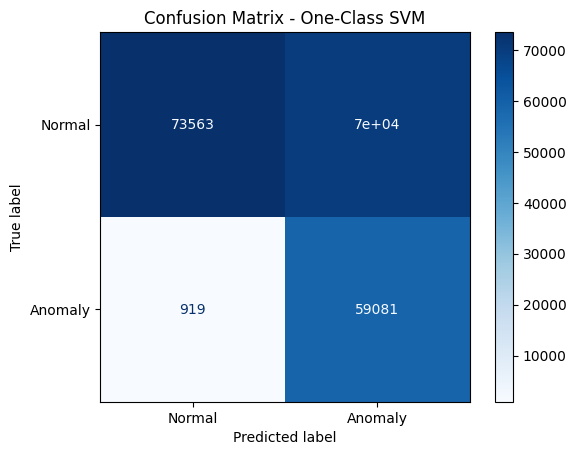

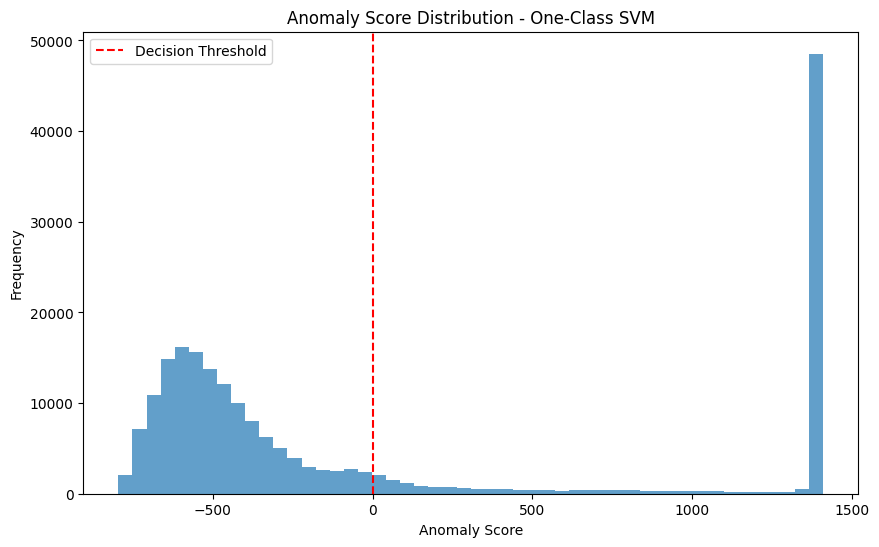

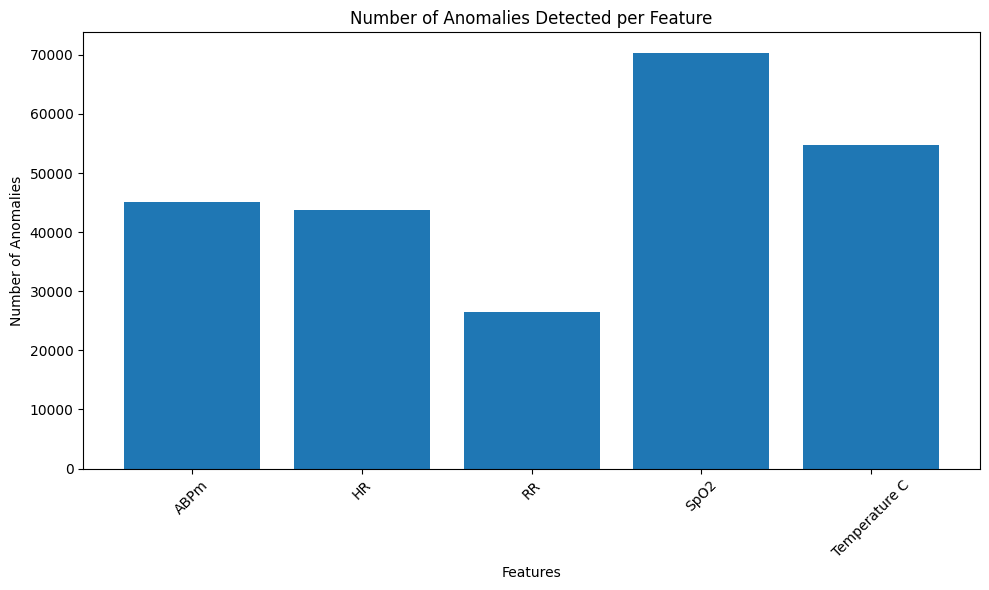

In [3]:
import numpy as np
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_and_detect_anomalies_one_class_svm(X_normal, X_test, Y, cols,
                                            nu=0.05, kernel='rbf', gamma='scale'):
    """
    Train One-Class SVM on normal data and detect anomalies in test data

    Args:
        X_normal: normal data (without anomalies)
        X_test: test data (potentially with anomalies)
        Y: labels for evaluation
        cols: column names
        nu: an upper bound on the fraction of training errors and a lower bound of the fraction of support vectors
        kernel: kernel type (rbf, linear, poly, sigmoid)
        gamma: kernel coefficient
    """
    # Initialize the model
    model = OneClassSVM(
        nu=nu,
        kernel=kernel,
        gamma=gamma
    )

    # Fit the model on normal data
    print("Training One-Class SVM model...")
    model.fit(X_normal)

    # Predict anomalies (1 for normal, -1 for anomalies)
    print("Detecting anomalies...")
    predictions_raw = model.predict(X_test)

    # Convert to binary labels (0 for normal, 1 for anomalies)
    anomalies_label = np.zeros(len(predictions_raw))
    anomalies_label[predictions_raw == -1] = 1

    # Get anomaly scores (decision function values; more negative = more anomalous)
    anomaly_scores = -model.decision_function(X_test)

    # Feature-specific anomalies using individual One-Class SVMs
    anomalies_dict = {}
    POINT_ANOMALIES = set()
    feature_models = {}

    for idx, col in enumerate(cols):
        # Train a separate model for each feature
        feature_model = OneClassSVM(
            nu=nu,
            kernel=kernel,
            gamma=gamma
        )

        # Reshape to 2D array with single feature
        X_normal_feature = X_normal[:, idx].reshape(-1, 1)
        X_test_feature = X_test[:, idx].reshape(-1, 1)

        # Fit and predict
        feature_model.fit(X_normal_feature)
        feature_predictions = feature_model.predict(X_test_feature)

        # Get indices of anomalies for this feature
        feature_anomalies = np.where(feature_predictions == -1)[0]

        # Store results
        anomalies_dict[col] = feature_anomalies
        POINT_ANOMALIES = POINT_ANOMALIES.union(set(feature_anomalies))
        feature_models[col] = feature_model

    # Convert to list for indexing
    POINT_ANOMALIES_list = list(POINT_ANOMALIES)

    # Create new binary labels based on feature-specific anomalies
    feature_based_labels = np.zeros(len(Y))
    feature_based_labels[POINT_ANOMALIES_list] = 1

    # Calculate metrics for overall model
    print("\n## Metrics for One-Class SVM (Overall)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], anomalies_label)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], anomalies_label)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], anomalies_label)}")

    # Calculate metrics for feature-based detection
    print("\n## Metrics for One-Class SVM (Feature-based)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], feature_based_labels)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], feature_based_labels)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], feature_based_labels)}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(Y['final_label'], feature_based_labels)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - One-Class SVM')
    plt.show()

    # Plot anomaly score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(anomaly_scores, bins=50, alpha=0.7)
    # Find threshold for classification
    threshold = np.min(anomaly_scores[predictions_raw == -1]) if any(predictions_raw == -1) else 0
    plt.axvline(threshold, color='r', linestyle='--', label=f'Decision Threshold')
    plt.title('Anomaly Score Distribution - One-Class SVM')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Visualize feature importance by comparing anomaly counts
    feature_anomaly_counts = [len(anomalies_dict[col]) for col in cols]
    plt.figure(figsize=(10, 6))
    plt.bar(cols, feature_anomaly_counts)
    plt.title('Number of Anomalies Detected per Feature')
    plt.xlabel('Features')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return feature_based_labels, anomaly_scores, anomalies_dict, POINT_ANOMALIES_list

# Example usage
if __name__ == "__main__":
    pass
    # Sample code to use the function:

    # 1. Load and prepare your data
    df = pd.read_csv('final_data2.csv')
    cols = ['ABPm', 'HR', 'RR', 'SpO2', 'Temperature C']
    labels = ['label', 'label2', 'final_label', 'final_label2']
    X = df[cols].values  # Convert to numpy array
    Y = df[labels]

    df_normal = pd.read_csv('df_500_patients.csv')
    df_normal.drop(columns=['ABPs', 'ABPd'], inplace=True)
    X_normal = df_normal[cols].values  # Convert to numpy array

    # 2. Scale your data
    scaler = MinMaxScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)
    X_scaled = scaler.transform(X)  # Use same scaler

    # 3. Run anomaly detection
    anomalies_label, anomaly_scores, anomalies_dict, POINT_ANOMALIES = train_and_detect_anomalies_one_class_svm(
        X_normal_scaled, X_scaled, Y, cols)


Detecting anomalies with LOF...


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(



## Metrics for Local Outlier Factor (Overall)
Accuracy for point anomaly detection: 0.6978457882902785
Precision for point anomaly detection: 0.4240549828178694
Recall for point anomaly detection: 0.07198333333333333

## Metrics for Local Outlier Factor (Feature-based)
Accuracy for point anomaly detection: 0.8691861321393856
Precision for point anomaly detection: 0.9966053242808648
Recall for point anomaly detection: 0.5578


/usr/local/lib/python3.11/dist-packages/sklearn/neighbors/_lof.py:322: UserWarning: Duplicate values are leading to incorrect results. Increase the number of neighbors for more accurate results.
  warnings.warn(


<Figure size 800x600 with 0 Axes>

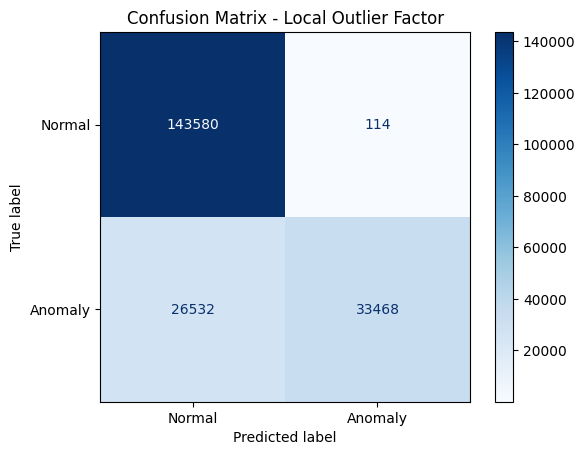

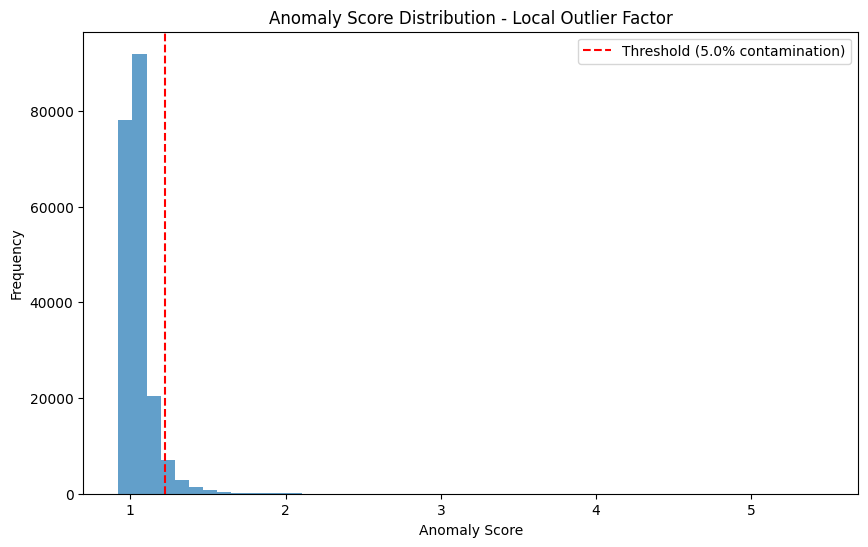

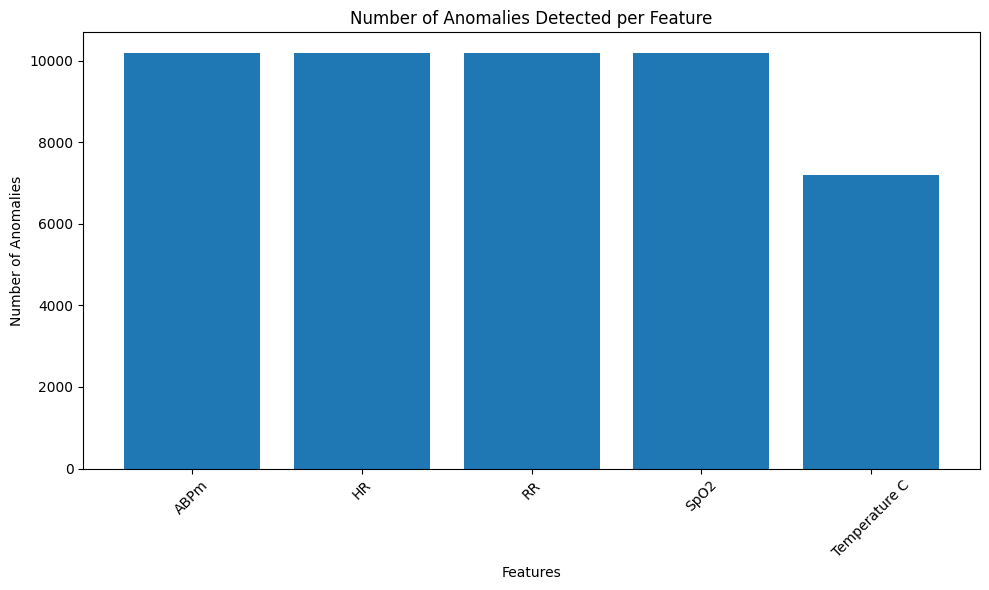

In [4]:
import numpy as np
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_and_detect_anomalies_lof(X_normal, X_test, Y, cols,
                                 n_neighbors=20, contamination=0.05):
    """
    Use Local Outlier Factor to detect anomalies

    Args:
        X_normal: normal data (without anomalies) - used only for reference
        X_test: test data (potentially with anomalies)
        Y: labels for evaluation
        cols: column names
        n_neighbors: number of neighbors to consider
        contamination: expected proportion of anomalies
    """
    # Initialize the model
    # Note: LOF works best using the test data directly with novelty=False (outlier detection mode)
    model = LocalOutlierFactor(
        n_neighbors=n_neighbors,
        contamination=contamination,
        novelty=False
    )

    # Fit and predict anomalies in one step
    print("Detecting anomalies with LOF...")
    predictions_raw = model.fit_predict(X_test)

    # Convert to binary labels (0 for normal, 1 for anomalies)
    anomalies_label = np.zeros(len(predictions_raw))
    anomalies_label[predictions_raw == -1] = 1

    # Get negative outlier factor scores (more negative = more anomalous)
    # The negative_outlier_factor_ is accessible after fitting
    anomaly_scores = -model.negative_outlier_factor_

    # Feature-specific anomalies using individual LOF models
    anomalies_dict = {}
    POINT_ANOMALIES = set()

    for idx, col in enumerate(cols):
        # Train a separate model for each feature
        feature_model = LocalOutlierFactor(
            n_neighbors=min(n_neighbors, X_test.shape[0]//2),  # Adjust neighbors for single feature
            contamination=contamination,
            novelty=False
        )

        # Reshape to 2D array with single feature
        X_test_feature = X_test[:, idx].reshape(-1, 1)

        # Fit and predict
        feature_predictions = feature_model.fit_predict(X_test_feature)

        # Get indices of anomalies for this feature
        feature_anomalies = np.where(feature_predictions == -1)[0]

        # Store results
        anomalies_dict[col] = feature_anomalies
        POINT_ANOMALIES = POINT_ANOMALIES.union(set(feature_anomalies))

    # Convert to list for indexing
    POINT_ANOMALIES_list = list(POINT_ANOMALIES)

    # Create new binary labels based on feature-specific anomalies
    feature_based_labels = np.zeros(len(Y))
    feature_based_labels[POINT_ANOMALIES_list] = 1

    # Calculate metrics for overall model
    print("\n## Metrics for Local Outlier Factor (Overall)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], anomalies_label)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], anomalies_label)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], anomalies_label)}")

    # Calculate metrics for feature-based detection
    print("\n## Metrics for Local Outlier Factor (Feature-based)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], feature_based_labels)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], feature_based_labels)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], feature_based_labels)}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(Y['final_label'], feature_based_labels)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Local Outlier Factor')
    plt.show()

    # Plot anomaly score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(anomaly_scores, bins=50, alpha=0.7)
    threshold = np.percentile(anomaly_scores, 100*(1-contamination))
    plt.axvline(threshold, color='r', linestyle='--',
                label=f'Threshold ({contamination*100}% contamination)')
    plt.title('Anomaly Score Distribution - Local Outlier Factor')
    plt.xlabel('Anomaly Score')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Visualize feature importance by comparing anomaly counts
    feature_anomaly_counts = [len(anomalies_dict[col]) for col in cols]
    plt.figure(figsize=(10, 6))
    plt.bar(cols, feature_anomaly_counts)
    plt.title('Number of Anomalies Detected per Feature')
    plt.xlabel('Features')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return feature_based_labels, anomaly_scores, anomalies_dict, POINT_ANOMALIES_list

# Example usage
if __name__ == "__main__":
    pass
    # Sample code to use the function:

    # 1. Load and prepare your data
    df = pd.read_csv('final_data2.csv')
    cols = ['ABPm', 'HR', 'RR', 'SpO2', 'Temperature C']
    labels = ['label', 'label2', 'final_label', 'final_label2']
    X = df[cols].values  # Convert to numpy array
    Y = df[labels]

    df_normal = pd.read_csv('df_500_patients.csv')
    df_normal.drop(columns=['ABPs', 'ABPd'], inplace=True)
    X_normal = df_normal[cols].values  # Convert to numpy array

    # 2. Scale your data
    scaler = MinMaxScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)
    X_scaled = scaler.transform(X)  # Use same scaler

    # 3. Run anomaly detection
    anomalies_label, anomaly_scores, anomalies_dict, POINT_ANOMALIES = train_and_detect_anomalies_lof(
        X_normal_scaled, X_scaled, Y, cols)


Training Gaussian Mixture Model...

## Metrics for Gaussian Mixture Model (Overall)
Accuracy for point anomaly detection: 0.7554419865091755
Precision for point anomaly detection: 1.0
Recall for point anomaly detection: 0.16975

## Metrics for Gaussian Mixture Model (Feature-based)
Accuracy for point anomaly detection: 0.8525484304888705
Precision for point anomaly detection: 0.9190791865961792
Recall for point anomaly detection: 0.5476333333333333


<Figure size 800x600 with 0 Axes>

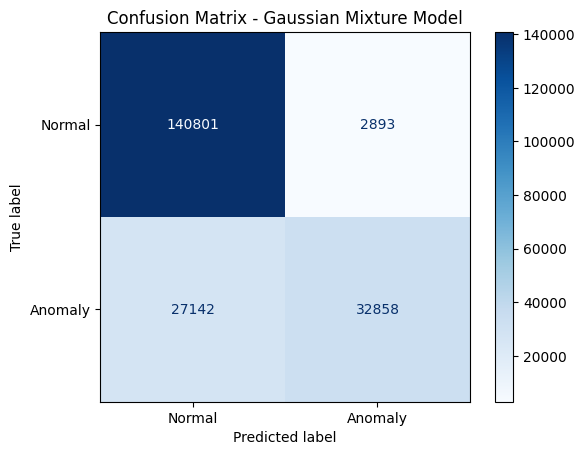

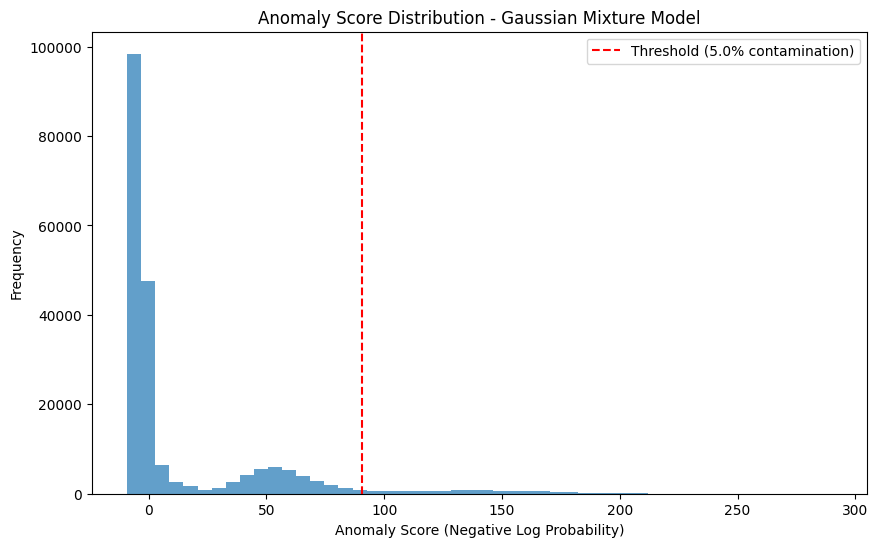

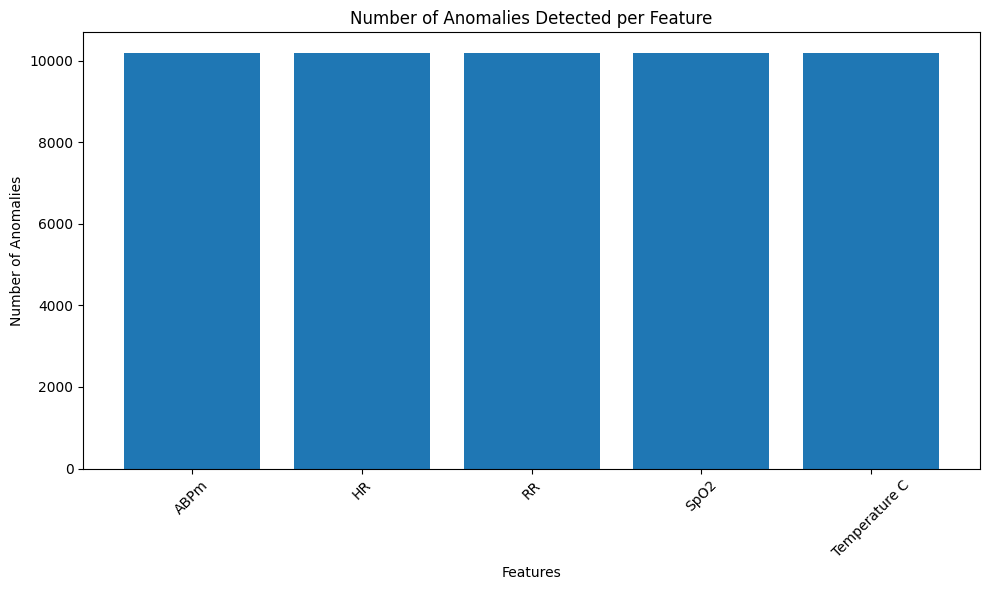

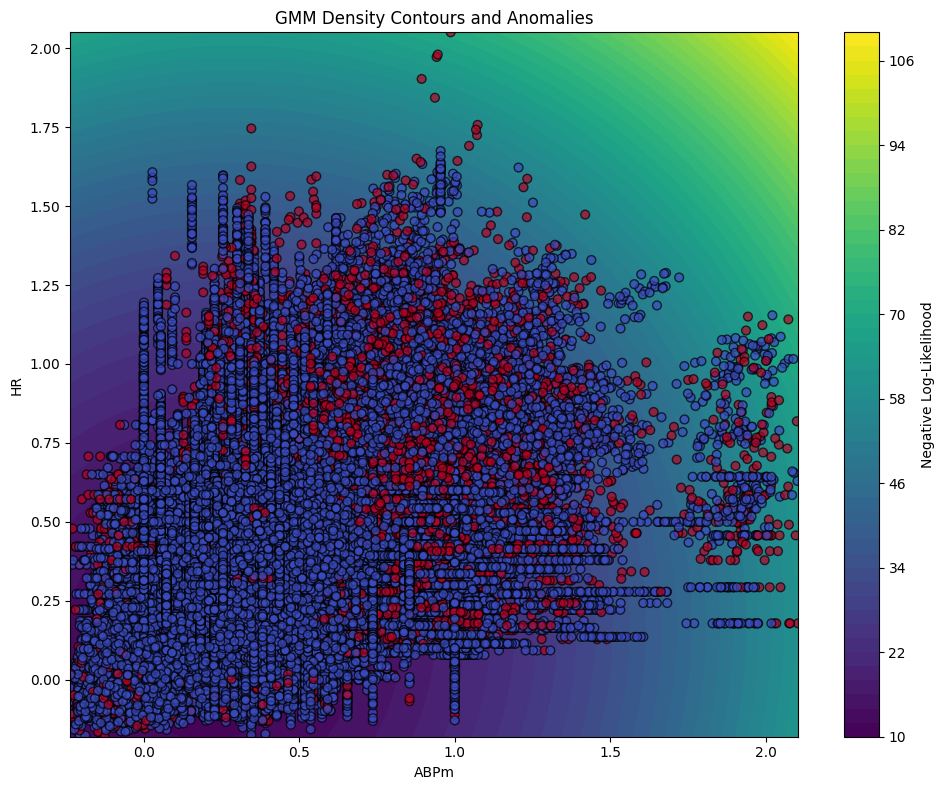

In [5]:
import numpy as np
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def train_and_detect_anomalies_gmm(X_normal, X_test, Y, cols,
                                 n_components=5, contamination=0.05,
                                 covariance_type='full', random_state=42):
    """
    Train Gaussian Mixture Model on normal data and detect anomalies in test data

    Args:
        X_normal: normal data (without anomalies)
        X_test: test data (potentially with anomalies)
        Y: labels for evaluation
        cols: column names
        n_components: number of mixture components
        contamination: expected proportion of anomalies
        covariance_type: type of covariance parameters ('full', 'tied', 'diag', 'spherical')
        random_state: for reproducibility
    """
    # Initialize the model
    model = GaussianMixture(
        n_components=n_components,
        covariance_type=covariance_type,
        random_state=random_state
    )

    # Fit the model on normal data
    print("Training Gaussian Mixture Model...")
    model.fit(X_normal)

    # Get log probability density for each sample (lower = more anomalous)
    log_probs = model.score_samples(X_test)
    anomaly_scores = -log_probs  # Invert so higher means more anomalous

    # Determine threshold based on contamination parameter
    threshold = np.percentile(anomaly_scores, 100 * (1 - contamination))

    # Create binary labels (0 for normal, 1 for anomalies)
    anomalies_label = np.zeros(len(anomaly_scores))
    anomalies_label[anomaly_scores > threshold] = 1

    # Feature-specific anomalies using individual GMMs
    anomalies_dict = {}
    POINT_ANOMALIES = set()
    feature_models = {}

    for idx, col in enumerate(cols):
        # Train a separate model for each feature
        # For a single feature, fewer components are typically needed
        feature_n_components = min(3, n_components)
        feature_model = GaussianMixture(
            n_components=feature_n_components,
            covariance_type=covariance_type,
            random_state=random_state
        )

        # Reshape to 2D array with single feature
        X_normal_feature = X_normal[:, idx].reshape(-1, 1)
        X_test_feature = X_test[:, idx].reshape(-1, 1)

        # Fit and score
        feature_model.fit(X_normal_feature)
        feature_scores = -feature_model.score_samples(X_test_feature)

        # Determine threshold for this feature
        feature_threshold = np.percentile(feature_scores, 100 * (1 - contamination))

        # Get indices of anomalies for this feature
        feature_anomalies = np.where(feature_scores > feature_threshold)[0]

        # Store results
        anomalies_dict[col] = feature_anomalies
        POINT_ANOMALIES = POINT_ANOMALIES.union(set(feature_anomalies))
        feature_models[col] = feature_model

    # Convert to list for indexing
    POINT_ANOMALIES_list = list(POINT_ANOMALIES)

    # Create new binary labels based on feature-specific anomalies
    feature_based_labels = np.zeros(len(Y))
    feature_based_labels[POINT_ANOMALIES_list] = 1

    # Calculate metrics for overall model
    print("\n## Metrics for Gaussian Mixture Model (Overall)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], anomalies_label)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], anomalies_label)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], anomalies_label)}")

    # Calculate metrics for feature-based detection
    print("\n## Metrics for Gaussian Mixture Model (Feature-based)")
    print(f"Accuracy for point anomaly detection: {accuracy_score(Y['final_label'], feature_based_labels)}")
    print(f"Precision for point anomaly detection: {precision_score(Y['final_label'], feature_based_labels)}")
    print(f"Recall for point anomaly detection: {recall_score(Y['final_label'], feature_based_labels)}")

    # Plot confusion matrix
    conf_matrix = confusion_matrix(Y['final_label'], feature_based_labels)
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - Gaussian Mixture Model')
    plt.show()

    # Plot anomaly score distribution
    plt.figure(figsize=(10, 6))
    plt.hist(anomaly_scores, bins=50, alpha=0.7)
    plt.axvline(threshold, color='r', linestyle='--',
                label=f'Threshold ({contamination*100}% contamination)')
    plt.title('Anomaly Score Distribution - Gaussian Mixture Model')
    plt.xlabel('Anomaly Score (Negative Log Probability)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    # Visualize feature importance by comparing anomaly counts
    feature_anomaly_counts = [len(anomalies_dict[col]) for col in cols]
    plt.figure(figsize=(10, 6))
    plt.bar(cols, feature_anomaly_counts)
    plt.title('Number of Anomalies Detected per Feature')
    plt.xlabel('Features')
    plt.ylabel('Number of Anomalies')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # If desired, visualize the GMM components for 2D projections
    if X_normal.shape[1] >= 2:
        # Take first two dimensions for visualization
        plt.figure(figsize=(10, 8))
        x = np.linspace(min(X_test[:, 0]), max(X_test[:, 0]), 100)
        y = np.linspace(min(X_test[:, 1]), max(X_test[:, 1]), 100)
        X, Y_mesh = np.meshgrid(x, y)
        XX = np.array([X.ravel(), Y_mesh.ravel()]).T

        # Complete with zeros for remaining dimensions if needed
        if X_normal.shape[1] > 2:
            XX_full = np.zeros((XX.shape[0], X_normal.shape[1]))
            XX_full[:, 0:2] = XX
            Z = -model.score_samples(XX_full)
        else:
            Z = -model.score_samples(XX)

        Z = Z.reshape(X.shape)

        plt.contourf(X, Y_mesh, Z, levels=50, cmap='viridis')
        plt.colorbar(label='Negative Log-Likelihood')
        plt.scatter(X_test[:, 0], X_test[:, 1], c=anomalies_label, cmap='coolwarm',
                   s=40, edgecolors='k', alpha=0.7)
        plt.title('GMM Density Contours and Anomalies')
        plt.xlabel(cols[0])
        plt.ylabel(cols[1])
        plt.tight_layout()
        plt.show()

    return feature_based_labels, anomaly_scores, anomalies_dict, POINT_ANOMALIES_list

# Example usage
if __name__ == "__main__":
    pass
    # Sample code to use the function:

    # 1. Load and prepare your data
    df = pd.read_csv('final_data2.csv')
    cols = ['ABPm', 'HR', 'RR', 'SpO2', 'Temperature C']
    labels = ['label', 'label2', 'final_label', 'final_label2']
    X = df[cols].values  # Convert to numpy array
    Y = df[labels]

    df_normal = pd.read_csv('df_500_patients.csv')
    df_normal.drop(columns=['ABPs', 'ABPd'], inplace=True)
    X_normal = df_normal[cols].values  # Convert to numpy array

    # 2. Scale your data
    scaler = MinMaxScaler()
    X_normal_scaled = scaler.fit_transform(X_normal)
    X_scaled = scaler.transform(X)  # Use same scaler

    # 3. Run anomaly detection
    anomalies_label, anomaly_scores, anomalies_dict, POINT_ANOMALIES = train_and_detect_anomalies_gmm(
        X_normal_scaled, X_scaled, Y, cols)
